In [1]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.optim.lr_scheduler import StepLR
import clip

from sklearn.metrics import accuracy_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Download Dataset**

Download the dataset from [this Kaggle link](https://www.kaggle.com/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp) and unzip it under your project folder


The entire possible answers form the answer space and the model answer questioned image by classifying the answer from answer space.


In [2]:
# load dataset
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","dataset","data_train.csv"),
        "test": os.path.join("..","dataset", "data_eval.csv")
    }
)

with open(os.path.join("..","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

image510


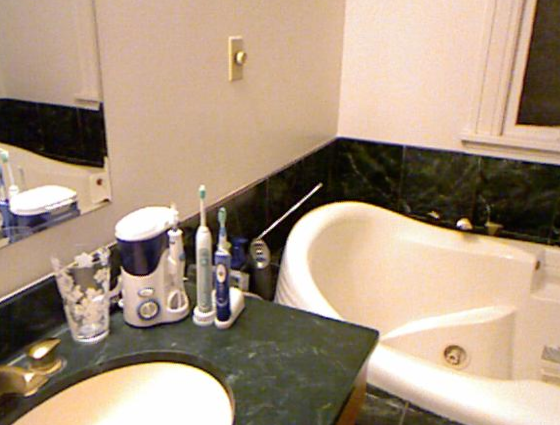

Question:	 what is right of sink
Answer:		 toothbrush (Label: 506)


In [3]:
# show instance of dataset
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    print(data[id]["image_id"])
    image = Image.open(os.path.join("..","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

In [4]:
# build tokenizer for question

from collections import defaultdict

train_dataset_loader = DataLoader(dataset["train"], batch_size=1, shuffle=False)

# Initialize the vocabulary with special tokens
q2i = defaultdict(lambda: len(q2i))
q2i['<pad>'] = 0  # Padding token
q2i['<unk>'] = 1  # Unknown word token

# Loop through the training data to build the vocabulary
for batch_id, batch in enumerate(train_dataset_loader):
    question = batch['question'][0]  
    words = question.lower().strip().split(" ")
    [q2i[word] for word in words]

q2i.default_factory = None
#print(q2i, len(q2i))

**Constructing Model**

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.nn.utils.rnn as rnn

class CoattentionNet(nn.Module):
    """
    Predicts an answer to a question about an image using the Hierarchical Question-Image Co-Attention
    for Visual Question Answering (Lu et al, 2017) paper.
    """
    def __init__(self, num_embeddings, num_classes, embed_dim=512, k=30):
        super().__init__()

        img_enc = models.resnet18(pretrained=True)
        modules = list(img_enc.children())[:-2]
        self.img_enc = nn.Sequential(*modules)
        for params in self.img_enc.parameters():
            params.requires_grad = False
    
        self.embed = nn.Embedding(num_embeddings, embed_dim)

        self.unigram_conv = nn.Conv1d(embed_dim, embed_dim, 1, stride=1, padding=0)
        self.bigram_conv  = nn.Conv1d(embed_dim, embed_dim, 2, stride=1, padding=1, dilation=2)
        self.trigram_conv = nn.Conv1d(embed_dim, embed_dim, 3, stride=1, padding=2, dilation=2)
        self.max_pool = nn.MaxPool2d((3, 1))
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=embed_dim, num_layers=3, dropout=0.4)
        self.tanh = nn.Tanh()

        self.W_b = nn.Parameter(torch.randn(embed_dim, embed_dim))
        self.W_v = nn.Parameter(torch.randn(k, embed_dim))
        self.W_q = nn.Parameter(torch.randn(k, embed_dim))
        self.w_hv = nn.Parameter(torch.randn(k, 1))
        self.w_hq = nn.Parameter(torch.randn(k, 1))

        self.W_w = nn.Linear(embed_dim, embed_dim)
        self.W_p = nn.Linear(embed_dim*2, embed_dim)
        self.W_s = nn.Linear(embed_dim*2, embed_dim)

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, image, question):                   
        # process image
        transform = ToTensor()
        image_tensor = transform(image)
        image_tensor = image_tensor.unsqueeze(0).to('cuda')
        imgT = self.img_enc(image_tensor)  # imgT: torch.Size([B, 512, 14, 18])
        image = imgT.view(imgT.size(0), imgT.size(1), -1) # imgT: torch.Size([B, 512, 252])
    
        # process question
        question = tokenize_question(question, q2i)
        #print(question.shape, question)
        question = rnn.pack_sequence([question])
        question, lens = rnn.pad_packed_sequence(question)
        question = question.permute(1, 0).to('cuda')                  
        words = self.embed(question).permute(0, 2, 1) # words: torch.Size([B, 512, L])
        
        unigrams = torch.unsqueeze(self.tanh(self.unigram_conv(words)), 2) # B x 512 x L
        bigrams  = torch.unsqueeze(self.tanh(self.bigram_conv(words)), 2)  # B x 512 x L
        trigrams = torch.unsqueeze(self.tanh(self.trigram_conv(words)), 2) # B x 512 x L
        words = words.permute(0, 2, 1)

        phrase = torch.squeeze(self.max_pool(torch.cat((unigrams, bigrams, trigrams), 2)))
        phrase = phrase.unsqueeze(0)
        phrase = phrase.permute(0, 2, 1)                                    # B x L x 512

        hidden = None
        phrase_packed = nn.utils.rnn.pack_padded_sequence(torch.transpose(phrase, 0, 1), lens)
        sentence_packed, hidden = self.lstm(phrase_packed, hidden)
        sentence, _ = rnn.pad_packed_sequence(sentence_packed)
        sentence = torch.transpose(sentence, 0, 1)                          # B x L x 512

        v_word, q_word = self.parallel_co_attention(image, words)
        v_phrase, q_phrase = self.parallel_co_attention(image, phrase)
        v_sent, q_sent = self.parallel_co_attention(image, sentence)

        h_w = self.tanh(self.W_w(q_word + v_word))
        h_p = self.tanh(self.W_p(torch.cat(((q_phrase + v_phrase), h_w))))
        h_s = self.tanh(self.W_s(torch.cat(((q_sent + v_sent), h_p))))

        
        logits = self.fc(h_s)

        #print("last word vector:", words.shape, words[0][-1][:10])
        return logits

    def parallel_co_attention(self, V, Q):  # V : B x 512 x 196, Q : B x L x 512
        C = torch.matmul(Q, torch.matmul(self.W_b, V)) # B x L x 196

        H_v = self.tanh(torch.matmul(self.W_v, V) + torch.matmul(torch.matmul(self.W_q, Q.permute(0, 2, 1)), C))                            # B x k x 196
        H_q = self.tanh(torch.matmul(self.W_q, Q.permute(0, 2, 1)) + torch.matmul(torch.matmul(self.W_v, V), C.permute(0, 2, 1)))           # B x k x L

        #a_v = torch.squeeze(fn.softmax(torch.matmul(torch.t(self.w_hv), H_v), dim=2)) # B x 196
        #a_q = torch.squeeze(fn.softmax(torch.matmul(torch.t(self.w_hq), H_q), dim=2)) # B x L

        a_v = fn.softmax(torch.matmul(torch.t(self.w_hv), H_v), dim=2) # B x 1 x 196
        a_q = fn.softmax(torch.matmul(torch.t(self.w_hq), H_q), dim=2) # B x 1 x L

        v = torch.squeeze(torch.matmul(a_v, V.permute(0, 2, 1))) # B x 512
        q = torch.squeeze(torch.matmul(a_q, Q))                  # B x 512

        return v, q

def tokenize_question(question, q2i):
    return torch.tensor([q2i.get(word, q2i['<unk>']) for word in question.lower().strip().split(" ")])

In [6]:
trainDataset = dataset['train']
subset_size = 1
subset_indices = list(range(subset_size))
SubDataset = Subset(trainDataset, subset_indices)
train_dataset_loader = DataLoader(SubDataset, batch_size=1, shuffle=True)

model = CoattentionNet(len(q2i), 582)
model.to('cuda')

for batch_id, batch in enumerate(train_dataset_loader):
    image_id = batch['image_id'][0]
    labels = batch['label']
    
    
    question = batch['question'][0]
    image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))
    
    predicted_logits = model(image, question)

C:\Users\Hu\anaconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Hu\anaconda3\envs\py311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


last word vector: torch.Size([1, 7, 512]) tensor([ 0.9264,  0.0452, -0.1757, -0.3475,  0.7459,  1.8408, -0.2917,  0.3683,
        -1.0583,  1.1313], device='cuda:0', grad_fn=<SliceBackward0>)


In [7]:
model = CoattentionNet(len(q2i), 582)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of learnable parameters: {total_params}")

W_b torch.Size([512, 512])
W_v torch.Size([30, 512])
W_q torch.Size([30, 512])
w_hv torch.Size([30, 1])
w_hq torch.Size([30, 1])
embed.weight torch.Size([1014, 512])
unigram_conv.weight torch.Size([512, 512, 1])
unigram_conv.bias torch.Size([512])
bigram_conv.weight torch.Size([512, 512, 2])
bigram_conv.bias torch.Size([512])
trigram_conv.weight torch.Size([512, 512, 3])
trigram_conv.bias torch.Size([512])
lstm.weight_ih_l0 torch.Size([2048, 512])
lstm.weight_hh_l0 torch.Size([2048, 512])
lstm.bias_ih_l0 torch.Size([2048])
lstm.bias_hh_l0 torch.Size([2048])
lstm.weight_ih_l1 torch.Size([2048, 512])
lstm.weight_hh_l1 torch.Size([2048, 512])
lstm.bias_ih_l1 torch.Size([2048])
lstm.bias_hh_l1 torch.Size([2048])
lstm.weight_ih_l2 torch.Size([2048, 512])
lstm.weight_hh_l2 torch.Size([2048, 512])
lstm.bias_ih_l2 torch.Size([2048])
lstm.bias_hh_l2 torch.Size([2048])
W_w.weight torch.Size([512, 512])
W_w.bias torch.Size([512])
W_p.weight torch.Size([512, 1024])
W_p.bias torch.Size([512])
W_s.w

In [42]:
class Model():
    def __init__(self, dataset, batch_size, num_epochs, lr=0.001, num_classes=582, check=False, save=False, checkpoint_epoch=0):
        self.num_classes = num_classes
        self.check = check
        self.save = save
        self.checkpoint_epoch = checkpoint_epoch

        if checkpoint_epoch > 0:
            self.model = CoattentionNet(len(q2i), 582)
            model_name = f"coatten_{checkpoint_epoch}_{0.001}_{1}.pth"
            self.model.load_state_dict(torch.load(model_name))
        else:
            self.model = CoattentionNet(len(q2i), 582)
        
        self._num_epochs = num_epochs
        self._batch_size = batch_size
        self._lr = lr

        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.DEVICE)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.initialize_weights()

        self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.6)

        trainDataset = dataset['train']
        subset_size = len(trainDataset)
        subset_indices = list(range(subset_size))
        SubDataset = Subset(trainDataset, subset_indices)
        self.train_dataset_loader = DataLoader(SubDataset, batch_size=1, shuffle=True)
        #self.val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

    def initialize_weights(self):
      for layer in self.model.modules():
          if not isinstance(layer, (nn.Conv2d, nn.Linear)):
              continue
          try:
              torch.nn.init.xavier_normal_(layer.weight)
              try:
                  nn.init.constant_(layer.bias.data, 0)
              except:
                  pass
          except:
              pass

    def train(self):
        train_losses = []
        print('Started Training.\n')
        for epoch in range(self._num_epochs - self.checkpoint_epoch):
            train_epcoh = self.checkpoint_epoch + epoch + 1
            if self.check:
                total_matches = 0
                total_samples = 0
                TP = 0
                FN = 0
                FP = 0
                TN = 0
      
            self.model.train()  # Set the model to training mode
            train_loss = 0.0
            for batch_id, batch in enumerate(self.train_dataset_loader):
                image_id = batch['image_id'][0]
                labels = batch['label']

                true_answer = torch.zeros(1, self.num_classes, dtype=torch.float32)
                for label in labels:
                    true_answer[0][label] = 1

                true_answer = true_answer.to(self.DEVICE)
                
                question = batch['question'][0]
                image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))

                predicted_logits = self.model(image, question)
                predicted_logits = predicted_logits.unsqueeze(0)
                
                self.optimizer.zero_grad()
                loss = self.criterion(predicted_logits, true_answer)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                if self.check:
                    predicted_probs = torch.softmax(predicted_logits, dim=1)
                    predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities
        
                    for j in range (0, len(predicted_labels[0])):
                        if predicted_labels[0][j] == 1:
                            if j in labels:
                                TP += 1
                            else:
                                FP += 1
                        else:
                            if j in labels:
                                FN += 1
                            else:
                                TN += 1
        
                    total_matches += ((predicted_labels == true_answer).sum()).item()
                    total_samples += len(labels)
                    
                if batch_id % 100 == 0:  # Log every 100 batches
                    print(f'Epoch [{train_epcoh}/{self._num_epochs+self.checkpoint_epoch}], Step [{batch_id}/{len(self.train_dataset_loader)}], Loss: {loss.item():.4f}')
                    if self.check:
                        precision = TP / (TP + FP) if TP + FP > 0 else 0
                        recall = TP / (TP + FN) if TP + FN > 0 else 0
                        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
                        accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0
                    
                        print(f'Epoch-batch: {train_epcoh}-{batch_id}, threshold: {threshold:.2f}')
                        print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
                        print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')
                        
            train_losses.append(train_loss/batch_id)

            self.scheduler.step()
            #print(f"Epoch {epoch+1}, Learning Rate: {self.scheduler.get_last_lr()}")

            print(f'Epoch [{train_epcoh}/{self._num_epochs+self.checkpoint_epoch}], Mean Loss: {train_loss/batch_id:.4f}')
            
            if self.save and (train_epcoh) % 5 == 0:
                model_name = f"coatten_{train_epcoh}_{0.001}_{self._batch_size}.pth"
                torch.save(self.model.state_dict(), model_name)
                
        print('Finished Training.')
        return train_losses

**Training**

In [43]:
num_epochs = 60
model = Model(dataset, batch_size=1, num_epochs=num_epochs, lr=0.001, check=False, save=True)
train_losses = model.train()

Started Training.

Epoch [1/60], Step [0/9974], Loss: 6.3912
Epoch [1/60], Step [100/9974], Loss: 2.8732
Epoch [1/60], Step [200/9974], Loss: 3.7758
Epoch [1/60], Step [300/9974], Loss: 4.8492
Epoch [1/60], Step [400/9974], Loss: 5.6455
Epoch [1/60], Step [500/9974], Loss: 7.2146
Epoch [1/60], Step [600/9974], Loss: 3.6158
Epoch [1/60], Step [700/9974], Loss: 2.0379
Epoch [1/60], Step [800/9974], Loss: 6.7960
Epoch [1/60], Step [900/9974], Loss: 3.1216
Epoch [1/60], Step [1000/9974], Loss: 3.5167
Epoch [1/60], Step [1100/9974], Loss: 5.9308
Epoch [1/60], Step [1200/9974], Loss: 8.5763
Epoch [1/60], Step [1300/9974], Loss: 4.0228
Epoch [1/60], Step [1400/9974], Loss: 7.3483
Epoch [1/60], Step [1500/9974], Loss: 9.4219
Epoch [1/60], Step [1600/9974], Loss: 5.9351
Epoch [1/60], Step [1700/9974], Loss: 6.7132
Epoch [1/60], Step [1800/9974], Loss: 7.0040
Epoch [1/60], Step [1900/9974], Loss: 4.6346
Epoch [1/60], Step [2000/9974], Loss: 4.8566
Epoch [1/60], Step [2100/9974], Loss: 2.8985
Epo

In [44]:
train_losses

[6.540806947916426,
 6.428808994913226,
 6.4381520178389025,
 6.437838021359137,
 6.418402553596791,
 6.4439873324166825,
 6.440996978899236,
 6.448412317181618,
 6.435623226828696,
 6.424329722183441,
 5.879721175317813,
 5.892672357785837,
 5.880447168503459,
 5.8830752097638745,
 5.883591993288017,
 5.8878794209261205,
 5.885077111857067,
 5.8881318217042,
 5.884937228296342,
 5.891958749737745,
 5.563445938502512,
 5.549414674066486,
 5.567021612870971,
 5.562236007245101,
 5.561814177769016,
 5.566579668019608,
 5.566564755443105,
 5.56078144071526,
 5.564593703245,
 5.564255390903075,
 5.362559078247249,
 5.366947466782291,
 5.363724352674428,
 5.355062199478031,
 5.354584725632491,
 5.3649100529852305,
 5.364259012350524,
 5.36269422795724,
 5.363988296110413,
 5.366111030803812,
 5.232645104728228,
 5.238434305296706,
 5.229425160800946,
 5.233369797746097,
 5.2365367883045195,
 5.232471313756745,
 5.236384953178781,
 5.236127132734969,
 5.240005095433199,
 5.232551248528039,
 

**Testing**

**Method 1: Using argmax**

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, epoch, threshold=None):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question'][0]
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            predicted_logits = predicted_logits.unsqueeze(0)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()
            
            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_probs = predicted_probs.squeeze(0)
            
            if torch.argmax(predicted_probs) == labels[0]:
                total_matches += 1
            total_samples += 1
            
            pbar.update(1)

    acc = total_matches/total_samples

    
    print(f'Epoch: {epoch}')
    print(f'Accuracy: {acc:.4f}')

    return acc

num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

epochs = [10, 20, 30, 40, 50, 60]
#epochs = [1]
performances = []
for epoch in epochs:
    
    model = CoattentionNet(len(q2i), 582)
    
    model_name = f"coatten_{epoch}_{0.001}_{1}.pth"
    model.load_state_dict(torch.load(model_name))
    model.to(device)  

    acc = validate(model, val_dataset_loader, device, num_classes, epoch)
    performances.append(acc)

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:47<00:00, 52.64it/s]


Epoch: 10
Accuracy: 0.0257


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:49<00:00, 50.68it/s]


Epoch: 20
Accuracy: 0.0044


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:49<00:00, 50.30it/s]


Epoch: 30
Accuracy: 0.0176


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:48<00:00, 51.24it/s]


Epoch: 40
Accuracy: 0.0449


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:49<00:00, 50.81it/s]


Epoch: 50
Accuracy: 0.0325


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:47<00:00, 52.24it/s]

Epoch: 60
Accuracy: 0.0325


**Method 2: Using softmax with threshold**

In [15]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, threshold, epoch):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question'][0]
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            predicted_logits = predicted_logits.unsqueeze(0)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()
            
            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities

            for j in range (0, len(predicted_labels[0])):
                if predicted_labels[0][j] == 1:
                    if j in labels:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if j in labels:
                        FN += 1
                    else:
                        TN += 1

            total_matches += ((predicted_labels == true_answer).sum()).item()
            total_samples += len(labels)

            '''
            print("max(predicted_logits)", max(predicted_logits[0]))
            print("mean(predicted_logits)", torch.mean(predicted_logits[0]))
            print("first 10 logits:", predicted_logits[0][:10])
            print("max(predicted_probs)", max(predicted_probs[0]))
            print("mean(predicted_probs)", torch.mean(predicted_probs[0]))
            print("first 10 logits:", predicted_probs[0][:10])
            print(question)
            print(labels)
            print(question)
            display(image)
            print(batch['answer'])
            '''
            
            pbar.update(1)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0

    print(f'Epoch: {epoch}, threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')

    return precision, recall

num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)

epochs = [10, 20, 30, 40, 50, 60]
#epochs = [1]
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
performances1 = []
for epoch in epochs:
    precisions = []
    recalls = []
    
    model = CoattentionNet(len(q2i), 582)
    
    model_name = f"coatten_{epoch}_{0.001}_{1}.pth"
    model.load_state_dict(torch.load(model_name))
    model.to(device)  

    for threshold in thresholds:
        precision, recall = validate(model, val_dataset_loader, device, num_classes, threshold, epoch)
        precisions.append(precision)
        recalls.append(recall)
    performances1.append((precisions, recalls))

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:25<00:00,  7.65it/s]


Epoch: 10, threshold: 0.10
Precision: 0.0257, Recall: 0.0257
F1 Score: 0.0257, Accuracy: 0.9967


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:22<00:00,  7.74it/s]


Epoch: 10, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:16<00:00,  7.89it/s]


Epoch: 10, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:11<00:00,  8.00it/s]


Epoch: 10, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:11<00:00,  8.01it/s]


Epoch: 10, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.98it/s]


Epoch: 20, threshold: 0.10
Precision: 0.0044, Recall: 0.0044
F1 Score: 0.0044, Accuracy: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.97it/s]


Epoch: 20, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:11<00:00,  7.99it/s]


Epoch: 20, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.99it/s]


Epoch: 20, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:11<00:00,  8.01it/s]


Epoch: 20, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:11<00:00,  8.02it/s]


Epoch: 30, threshold: 0.10
Precision: 0.0176, Recall: 0.0176
F1 Score: 0.0176, Accuracy: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.97it/s]


Epoch: 30, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.99it/s]


Epoch: 30, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.99it/s]


Epoch: 30, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.95it/s]


Epoch: 30, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.99it/s]


Epoch: 40, threshold: 0.10
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.96it/s]


Epoch: 40, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.94it/s]


Epoch: 40, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.97it/s]


Epoch: 40, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:12<00:00,  7.97it/s]


Epoch: 40, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.94it/s]


Epoch: 50, threshold: 0.10
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.96it/s]


Epoch: 50, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.94it/s]


Epoch: 50, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.97it/s]


Epoch: 50, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.94it/s]


Epoch: 50, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.96it/s]


Epoch: 60, threshold: 0.10
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.94it/s]


Epoch: 60, threshold: 0.30
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.95it/s]


Epoch: 60, threshold: 0.50
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:14<00:00,  7.94it/s]


Epoch: 60, threshold: 0.70
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [05:13<00:00,  7.95it/s]

Epoch: 60, threshold: 0.90
Precision: 0.0000, Recall: 0.0000
F1 Score: 0.0000, Accuracy: 0.9983
